# Project 3
## Task 3: Deep Anomaly Detection and Data Representation

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.svm import OneClassSVM

from sklearn.decomposition import PCA

from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch

import torch
import random

In [2]:
# ============================================================================
# REPORT-COMPLIANT PLOT CONFIGURATION
# ============================================================================
# Set consistent style for all plots
plt.style.use('seaborn-v0_8-whitegrid')

# Global matplotlib parameters for report-quality figures
plt.rcParams.update({
    # Figure size (width, height) in inches - suitable for reports
    'figure.figsize': (8, 5),
    'figure.dpi': 150,

    # Font sizes
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'legend.title_fontsize': 11,

    # Font weight
    'axes.titleweight': 'bold',
    'axes.labelweight': 'bold',

    # Line widths
    'axes.linewidth': 1.2,
    'grid.linewidth': 0.8,
    'lines.linewidth': 1.5,

    # Grid style
    'grid.alpha': 0.3,
    'grid.linestyle': '--',

    # Save figure settings
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
})

# Color palette for consistency
REPORT_COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72',
    'tertiary': '#F18F01',
    'quaternary': '#C73E1D',
    'normal': '#2E86AB',
    'anomaly': '#F18F01'
}
# ============================================================================

In [3]:
# Seed al the libraries to ensure reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # for multi-GPU setups

# Example: setting a seed for reproducibility
set_seed(33)

## Helper functions

In [4]:
# ============================================================================
# GLOBAL CONFIGURATION: Plot Saving
# ============================================================================
SAVE_PLOTS = True
# ============================================================================

REPORT_IMAGES_DIR = '../Plots/Task3'
os.makedirs(REPORT_IMAGES_DIR, exist_ok=True)

def save_figure_for_report(filename, dpi=300, bbox_inches='tight'):
    """
    Persist the current matplotlib figure under the Task 3 plots directory.

    Args:
        filename: Target filename such as 'task3_autoencoder_loss.png'.
        dpi: Output resolution (defaults to 300).
        bbox_inches: Matplotlib bounding box mode (defaults to 'tight').
    """
    if not SAVE_PLOTS or not filename:
        return

    filepath = os.path.join(REPORT_IMAGES_DIR, filename)
    plt.savefig(filepath, dpi=dpi, bbox_inches=bbox_inches)
    print(f"Figure saved to: {filepath}")

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The device is set to: {device}")

The device is set to: cpu


In [6]:
def print_combined_classification_reports(y_true_train, y_pred_train,
                                         y_true_val, y_pred_val,
                                         y_true_test, y_pred_test):
    """
    Print classification reports for train, validation, and test sets in a compact format.

    Args:
        y_true_train, y_pred_train: True and predicted labels for training set
        y_true_val, y_pred_val: True and predicted labels for validation set
        y_true_test, y_pred_test: True and predicted labels for test set
        class_names: List of class names
    """

    # Calculate metrics for each set
    train_prec, train_rec, train_f1, train_support = precision_recall_fscore_support(y_true_train, y_pred_train, average=None, zero_division=0)
    val_prec, val_rec, val_f1, val_support = precision_recall_fscore_support(y_true_val, y_pred_val, average=None, zero_division=0)
    test_prec, test_rec, test_f1, test_support = precision_recall_fscore_support(y_true_test, y_pred_test, average=None, zero_division=0)

    train_acc = accuracy_score(y_true_train, y_pred_train)
    val_acc = accuracy_score(y_true_val, y_pred_val)
    test_acc = accuracy_score(y_true_test, y_pred_test)

    # Print compact report
    print("\n" + "="*125)
    print("CLASSIFICATION REPORT: Train / Validation / Test")
    print("="*125)
    print(f"{'Class':<20} {'Precision':<25} {'Recall':<25} {'F1-Score':<25} {'Support':<25}")
    print(f"{'':20} {'Train Val  Test':<25} {'Train Val  Test':<25} {'Train Val  Test':<25} {'Train  Val   Test':<25}")
    print("-"*125)

    for idx in range(2):
        print(f"{idx:<20}"
              f"{train_prec[idx]:>5.2f} {val_prec[idx]:>5.2f} {test_prec[idx]:>5.2f}\t      "
              f"{train_rec[idx]:>5.2f} {val_rec[idx]:>5.2f} {test_rec[idx]:>5.2f}\t\t"
              f"{train_f1[idx]:>5.2f} {val_f1[idx]:>5.2f} {test_f1[idx]:>5.2f}\t   "
              f"{train_support[idx]:>5} {val_support[idx]:>5} {test_support[idx]:>5}")

    print("-"*125)
    print(f"{'Accuracy':<20}{train_acc:>5.2f} {val_acc:>5.2f} {test_acc:>5.2f}")
    print("="*125)


In [7]:
def plot_confusion_matrices_combined(y_true_list, y_pred_list, class_names, titles, save_name=None):
    """
    Creates a combined figure with multiple confusion matrices in one row.

    Args:
        y_true_list: List of true labels arrays [train, val, test]
        y_pred_list: List of predicted labels arrays [train, val, test]
        class_names: List of class names for axis labels
        titles: List of titles for each subplot
        save_name: Optional filename for the consolidated confusion matrices.
    """
    fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))

    for idx, (y_true, y_pred, title, ax) in enumerate(zip(y_true_list, y_pred_list, titles, axes)):
        cm = confusion_matrix(y_true, y_pred)

        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={'size': 10},
                   xticklabels=class_names, yticklabels=class_names,
                   ax=ax, cbar_kws={'label': 'Count'})

        ax.set_xlabel("Predicted Label")
        ax.set_ylabel("True Label")
        ax.set_title(title, fontsize=11, fontweight='bold', pad=10)
        ax.tick_params(labelsize=9)

    plt.tight_layout()
    if save_name:
        save_figure_for_report(save_name)
    plt.show()

### Load the datasets

In [8]:
df_train = pd.read_csv('../data/preprocessed/train_preprocessed.csv')
df_test = pd.read_csv('../data/preprocessed/test_preprocessed.csv')

In [9]:
df_train_normal_only = df_train[df_train["binary_label"]==0].copy()
X_full_train_normal_only = df_train_normal_only.drop(columns=['label', 'binary_label'])
y_full_train_normal_only = list(df_train_normal_only['binary_label'])

X_train_normal_only, X_val, y_train_normal_only, y_val = train_test_split(X_full_train_normal_only, y_full_train_normal_only, test_size=0.2, random_state=42)

X_train = df_train.drop(columns=['label', 'binary_label'])
y_original_train = list(df_train['label'])
y_train = list(df_train['binary_label'])

X_test = df_test.drop(columns=['label', 'binary_label'])
y_original_test = list(df_test['label'])
y_test = list(df_test['binary_label'])

### Training and Validating Autoencoder with Normal data only

### Learning Rate Grid Search and Model Selection

**Question:** How did you select the learning rate and the number of epochs for the autoencoder? How did you use the validation set?

**Answer:**
- We performed a grid search over four learning rates: 0.005, 0.001, 0.0005 and 0.0001. For each learning rate, the autoencoder was trained for 1000 epochs using only normal data, and both training and validation losses were tracked at each epoch.
- For each run, we plotted the training and validation loss curves to visually inspect convergence and overfitting.
- The best model was selected based on the lowest validation loss achieved during training. The model weights corresponding to this minimum validation loss were saved and loaded for all subsequent analysis.
- This approach ensures that the chosen learning rate and model are those that generalize best to unseen (normal) data, as measured by the validation set.

**Conclusion:**
- The validation set was used both to monitor overfitting and to select the optimal learning rate and model checkpoint.
- This procedure follows best practices for model selection and ensures robust performance on unseen data.


In [10]:
class ImprovedAutoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim=16):
        super(ImprovedAutoencoder, self).__init__()

        # Encoder: deeper network, batchnorm, dropout
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, bottleneck_dim)
        )

        # Decoder: symmetric structure
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)     # bottleneck representation
        x_hat = self.decoder(z) # reconstruction
        return x_hat

    def encode(self, x):
        return self.encoder(x)  # return bottleneck representation


In [11]:
X_full_train_normal_tensor = torch.tensor(X_full_train_normal_only.values, dtype=torch.float32)
X_train_normal_tensor = torch.tensor(X_train_normal_only.values, dtype=torch.float32)
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

y_full_train_normal_tensor = torch.tensor(y_full_train_normal_only, dtype=torch.long)
y_train_normal_tensor = torch.tensor(y_train_normal_only, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create dataset and dataloader
train_normal_dataset = TensorDataset(X_train_normal_tensor)
train_normal_dataloader = DataLoader(train_normal_dataset, batch_size=64, shuffle=True, worker_init_fn=lambda _: np.random.seed(42))
train_dataset = TensorDataset(X_train_tensor)
# Are we sure whether to shuffle here?
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, worker_init_fn=lambda _: np.random.seed(42))
val_dataset = TensorDataset(X_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataset = TensorDataset(X_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [12]:
def mixed_autoencoder_loss(x, x_recon, categorical_dims, numerical_idx):
    """
    Needed because we have numerical + categorical features!

    Args:
        x: original input [batch_size, num_features]
        x_recon: reconstructed input [batch_size, num_features]
        categorical_dims: list of (start_idx, end_idx) tuples for one-hot encoded categorical features
        numerical_idx: list of indices for numerical features

    Returns:
        Scalar loss value (MSE + sum of CE)
    """
    # Numerical loss (MSE)
    x_num = x[:, numerical_idx]
    x_recon_num = x_recon[:, numerical_idx]
    mse = F.mse_loss(x_recon_num, x_num)

    # Categorical loss (CE for each one-hot feature)
    ce = 0
    for start, end in categorical_dims:
        x_cat = x[:, start:end]
        x_recon_cat = x_recon[:, start:end]

        # CE expects class indices as targets
        target = torch.argmax(x_cat, dim=1)
        ce += F.cross_entropy(x_recon_cat, target)

    return mse + ce


def compute_per_sample_reconstruction_error(x, x_recon, categorical_dims, numerical_idx):
    """
    Returns a vector [batch_size] with the total reconstruction error (MSE + sum CE) for each sample
    """
    batch_size = x.shape[0]

    # Numerical error per sample
    x_num = x[:, numerical_idx]
    x_recon_num = x_recon[:, numerical_idx]
    mse_per_sample = torch.mean((x_num - x_recon_num) ** 2, dim=1)

    # Categorical CE error per sample (sum across categorical features)
    ce_total = torch.zeros(batch_size, device=x.device)
    for start, end in categorical_dims:
        x_cat = x[:, start:end]
        x_recon_cat = x_recon[:, start:end]

        target = torch.argmax(x_cat, dim=1)
        ce = F.cross_entropy(x_recon_cat, target, reduction='none')  # shape: [batch_size]
        ce_total += ce

    # Total reconstruction error per sample
    return mse_per_sample + ce_total


In [13]:
#Indexes to compute the loss function based on MSE and CE for categorical features
# Step 1: Get all column names
all_columns = [col for col in df_train_normal_only.columns if col not in ['label', 'binary_label']]

# Step 2: Get categorical index ranges
categorical_cols = ['protocol_type', 'service', 'flag']
categorical_dims = []
for col in categorical_cols:
    # Get all one-hot columns for this categorical feature
    one_hot_cols = [c for c in all_columns if c.startswith(col + "_")]
    if one_hot_cols:
        start_idx = all_columns.index(one_hot_cols[0])
        end_idx = start_idx + len(one_hot_cols)
        categorical_dims.append((start_idx, end_idx))

# Step 3: Get numerical column indexes
numerical_idx = [i for i, col in enumerate(all_columns)
                 if not any(col.startswith(c + "_") for c in categorical_cols)]

In [14]:
# Instantiate the autoencoder and optimizer
input_dim = X_train_normal_only.shape[1]
model = ImprovedAutoencoder(input_dim=input_dim, bottleneck_dim=16)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


=== Training with learning rate: 0.005 ===
Epoch 1/100, Loss: 0.0143, Val Loss: 0.0098
Epoch 11/100, Loss: 0.0057, Val Loss: 0.0134
Epoch 21/100, Loss: 0.0052, Val Loss: 0.0350
Epoch 31/100, Loss: 0.0043, Val Loss: 0.0176
Epoch 41/100, Loss: 0.0039, Val Loss: 0.0309
Epoch 51/100, Loss: 0.0031, Val Loss: 0.0171
Epoch 61/100, Loss: 0.0028, Val Loss: 0.0235
Epoch 71/100, Loss: 0.0026, Val Loss: 0.0190
Epoch 81/100, Loss: 0.0027, Val Loss: 0.0265
Epoch 91/100, Loss: 0.0023, Val Loss: 0.0122
Figure saved to: ../Plots/Task3/task3_autoencoder_train_val_loss_lr_0.005.png


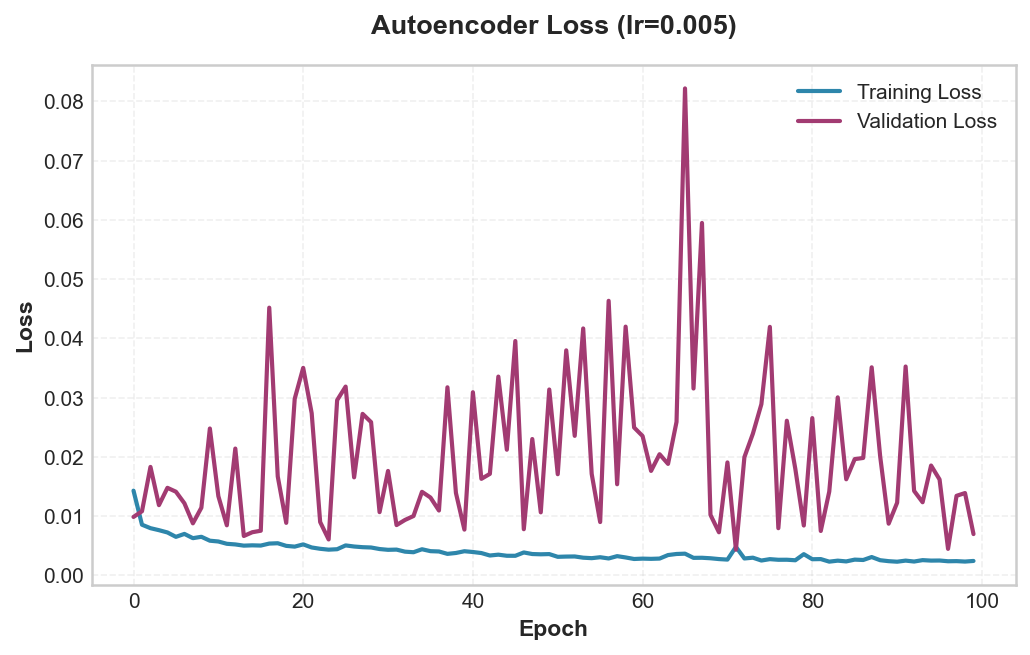


=== Training with learning rate: 0.001 ===
Epoch 1/100, Loss: 0.0250, Val Loss: 0.0147
Epoch 11/100, Loss: 0.0062, Val Loss: 0.0099
Epoch 21/100, Loss: 0.0054, Val Loss: 0.0107
Epoch 31/100, Loss: 0.0048, Val Loss: 0.0111
Epoch 41/100, Loss: 0.0045, Val Loss: 0.0050
Epoch 51/100, Loss: 0.0039, Val Loss: 0.0038
Epoch 61/100, Loss: 0.0035, Val Loss: 0.0108
Epoch 71/100, Loss: 0.0034, Val Loss: 0.0048
Epoch 81/100, Loss: 0.0033, Val Loss: 0.0081
Epoch 91/100, Loss: 0.0030, Val Loss: 0.0038
Figure saved to: ../Plots/Task3/task3_autoencoder_train_val_loss_lr_0.001.png


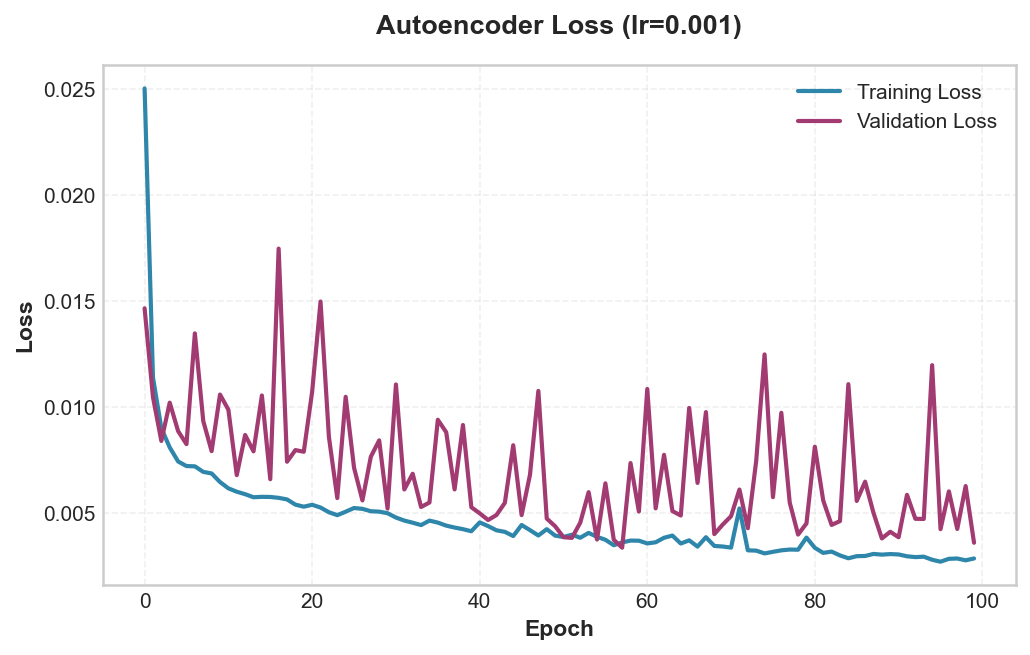


=== Training with learning rate: 0.0005 ===
Epoch 1/100, Loss: 0.0353, Val Loss: 0.0191
Epoch 11/100, Loss: 0.0069, Val Loss: 0.0093
Epoch 21/100, Loss: 0.0059, Val Loss: 0.0109
Epoch 31/100, Loss: 0.0052, Val Loss: 0.0083
Epoch 41/100, Loss: 0.0051, Val Loss: 0.0079
Epoch 51/100, Loss: 0.0044, Val Loss: 0.0045
Epoch 61/100, Loss: 0.0040, Val Loss: 0.0064
Epoch 71/100, Loss: 0.0038, Val Loss: 0.0045
Epoch 81/100, Loss: 0.0038, Val Loss: 0.0049
Epoch 91/100, Loss: 0.0035, Val Loss: 0.0030
Figure saved to: ../Plots/Task3/task3_autoencoder_train_val_loss_lr_0.0005.png


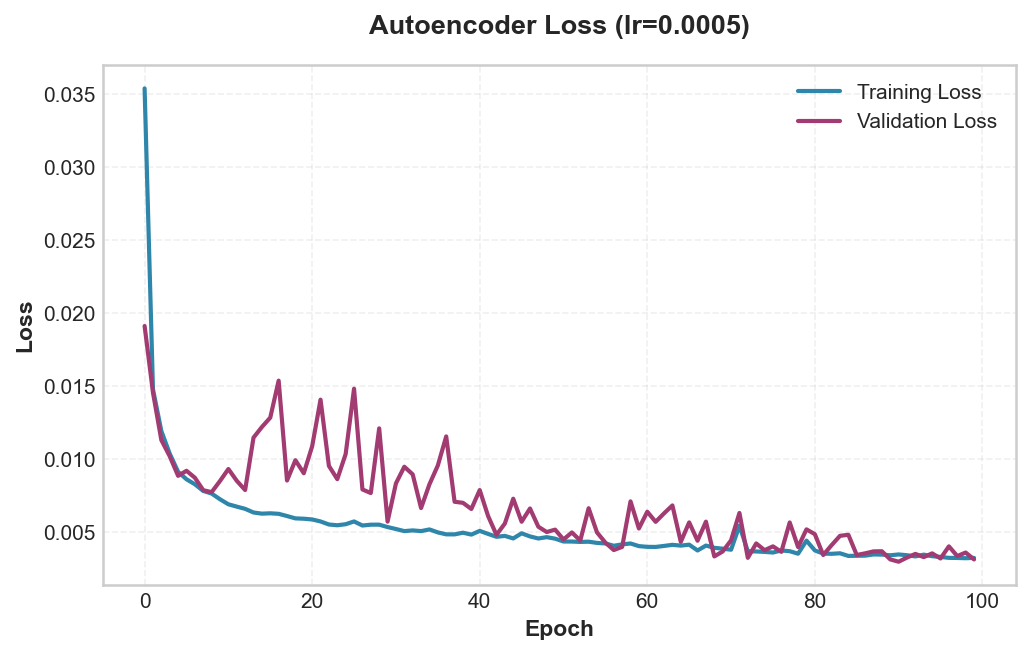


=== Training with learning rate: 0.0001 ===
Epoch 1/100, Loss: 0.0718, Val Loss: 0.0544
Epoch 11/100, Loss: 0.0126, Val Loss: 0.0133
Epoch 21/100, Loss: 0.0091, Val Loss: 0.0091
Epoch 31/100, Loss: 0.0077, Val Loss: 0.0080
Epoch 41/100, Loss: 0.0073, Val Loss: 0.0095
Epoch 51/100, Loss: 0.0065, Val Loss: 0.0102
Epoch 61/100, Loss: 0.0061, Val Loss: 0.0151
Epoch 71/100, Loss: 0.0059, Val Loss: 0.0080
Epoch 81/100, Loss: 0.0057, Val Loss: 0.0115
Epoch 91/100, Loss: 0.0055, Val Loss: 0.0079
Figure saved to: ../Plots/Task3/task3_autoencoder_train_val_loss_lr_0.0001.png


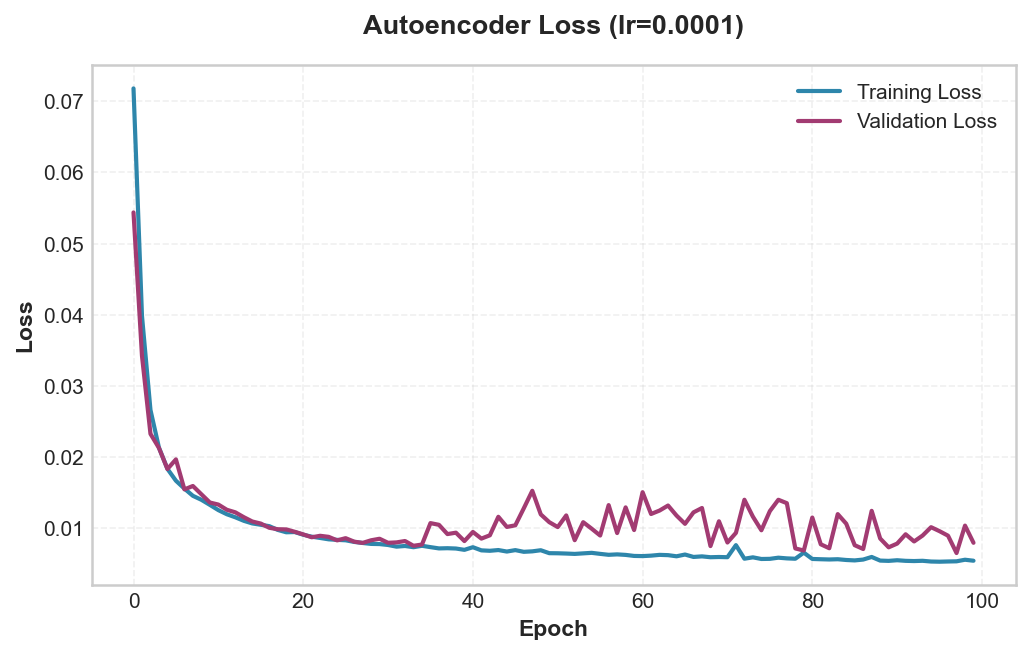


Grid search results (best val loss):
Learning rate 0.005: best val loss = 0.0043
Learning rate 0.001: best val loss = 0.0033
Learning rate 0.0005: best val loss = 0.0030
Learning rate 0.0001: best val loss = 0.0065

Best learning rate: 0.0005 (val loss = 0.0030, epoch=97)


In [15]:
# Grid search over learning rates for the autoencoder
from numpy import argmin


learning_rates = [5e-3, 1e-3, 5e-4, 1e-4]
n_epochs = 100
results = {}
best_val_loss = float('inf')
best_model_state = None
best_lr = None

# Store all loss curves for each learning rate
loss_curves = {}  # {lr: {'train': [...], 'val': [...]}}

for lr in learning_rates:
    print(f"\n=== Training with learning rate: {lr} ===")
    set_seed(33)
    # Re-initialize model and optimizer for each run
    model = ImprovedAutoencoder(input_dim=X_train_normal_only.shape[1], bottleneck_dim=16).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    val_losses = []
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        for batch in train_normal_dataloader:
            x_batch = batch[0].to(device)
            optimizer.zero_grad()
            x_hat = model(x_batch)
            loss = mixed_autoencoder_loss(x_batch, x_hat, categorical_dims, numerical_idx)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(X_train_normal_tensor)
        train_losses.append(train_loss)

        # Validation loss
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for batch in val_dataloader:
                x_batch = batch[0].to(device)
                x_hat = model(x_batch)
                loss = mixed_autoencoder_loss(x_batch, x_hat, categorical_dims, numerical_idx)
                val_loss += loss.item()
        val_loss /= len(X_val_tensor)
        val_losses.append(val_loss)
        if (epoch%10==0):
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Store the best validation loss for this learning rate
    min_val = min(val_losses)
    min_val_epoch = argmin(val_losses)
    results[lr] = min_val
    if min_val < best_val_loss:
        best_val_loss = min_val
        best_model_state = model.state_dict()
        best_lr = lr
        best_epoch= min_val_epoch

    # Store loss curves for later plotting
    loss_curves[lr] = {'train': train_losses, 'val': val_losses}

    # Plot both training and validation loss curves
    plt.figure(figsize=(7, 4.5))
    plt.plot(train_losses, linewidth=2, color='#2E86AB', label='Training Loss')
    plt.plot(val_losses, linewidth=2, color='#A23B72', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Autoencoder Loss (lr={lr})', pad=15)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend()
    plt.tight_layout()
    save_figure_for_report(f'task3_autoencoder_train_val_loss_lr_{lr}.png')
    plt.show()
    plt.close()

# Print summary
print("\nGrid search results (best val loss):")
for lr, best_val in results.items():
    print(f"Learning rate {lr}: best val loss = {best_val:.4f}")
print(f"\nBest learning rate: {best_lr} (val loss = {best_val_loss:.4f}, epoch={min_val_epoch})")

# Load the best model for further use
def load_best_autoencoder():
    model = ImprovedAutoencoder(input_dim=X_train_normal_only.shape[1], bottleneck_dim=16).to(device)
    model.load_state_dict(best_model_state)
    return model

# Set model to best for downstream cells
model = load_best_autoencoder()

Figure saved to: ../Plots/Task3/task3_autoencoder_all_train_val_loss_comparison.png


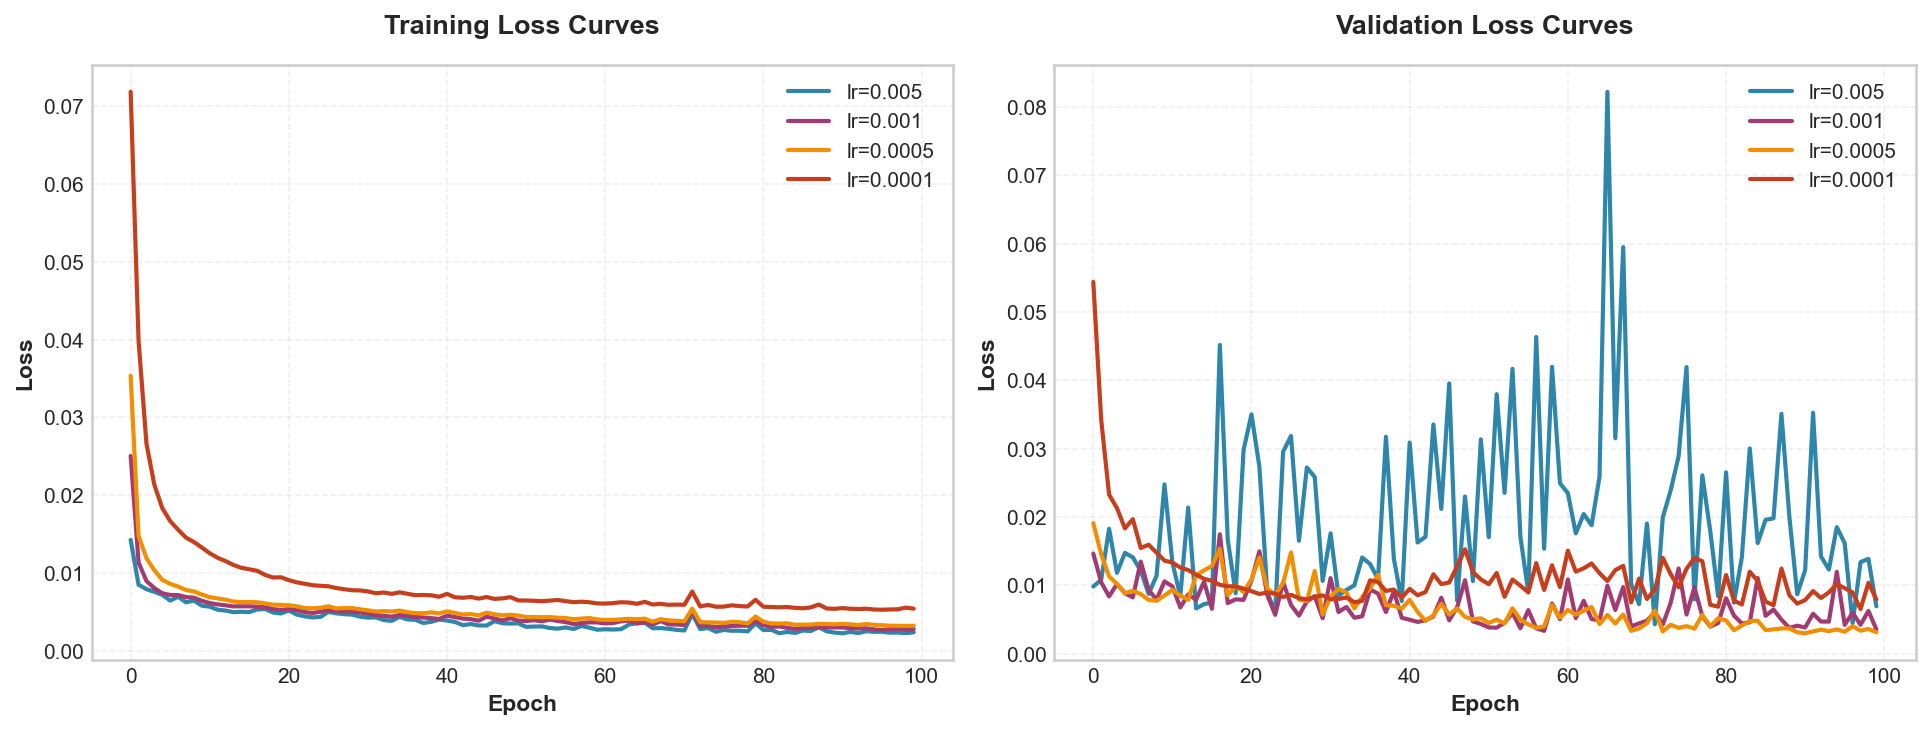

In [16]:
# Plot all training and validation loss curves for all learning rates in a single figure (no retraining, just using stored loss_curves)
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
labels = [f'lr={lr}' for lr in learning_rates]

for idx, lr in enumerate(learning_rates):
    train_losses = loss_curves[lr]['train']
    val_losses = loss_curves[lr]['val']
    axes[0].plot(train_losses, label=labels[idx], color=colors[idx], linewidth=2)
    axes[1].plot(val_losses, label=labels[idx], color=colors[idx], linewidth=2)

axes[0].set_title('Training Loss Curves', pad=15)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].legend()

axes[1].set_title('Validation Loss Curves', pad=15)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].grid(True, alpha=0.3, linestyle='--')
axes[1].legend()

plt.tight_layout()
save_figure_for_report('task3_autoencoder_all_train_val_loss_comparison.png')
plt.show()
plt.close()

Figure saved to: ../Plots/Task3/task3_autoencoder_all_train_loss.png


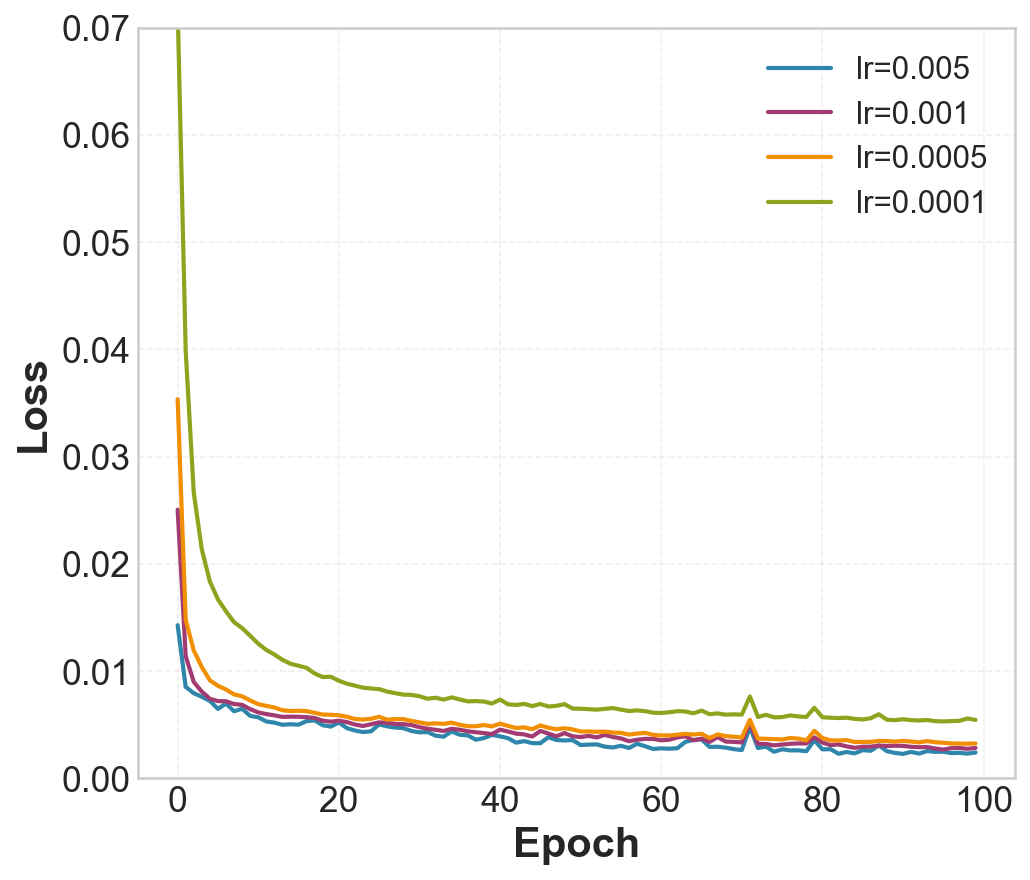

In [17]:
# Plot all training and validation loss curves for all learning rates in a single figure (no retraining, just using stored loss_curves)
LABEL_FONTSIZE = 20
TICK_FONTSIZE = 17
LEGEND_FONTSIZE = 15
LINE_WIDTH = 3.2
plt.figure(figsize=(7, 6))

colors = ['#2E86AB', '#A23B72', '#F18F01', '#8FA31E']
labels = [f'lr={lr}' for lr in learning_rates]

for idx, lr in enumerate(learning_rates):
    train_losses = loss_curves[lr]['train']
    plt.plot(train_losses, label=labels[idx], color=colors[idx], linewidth=2)

plt.xlabel('Epoch', fontsize=LABEL_FONTSIZE)
plt.ylabel('Loss', fontsize=LABEL_FONTSIZE)
plt.ylim(0, 0.07)
plt.tick_params(labelsize=TICK_FONTSIZE)
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(fontsize=LEGEND_FONTSIZE)

plt.tight_layout()
save_figure_for_report('task3_autoencoder_all_train_loss.png')
plt.show()
plt.close()


Figure saved to: ../Plots/Task3/task3_autoencoder_all_val_loss.png


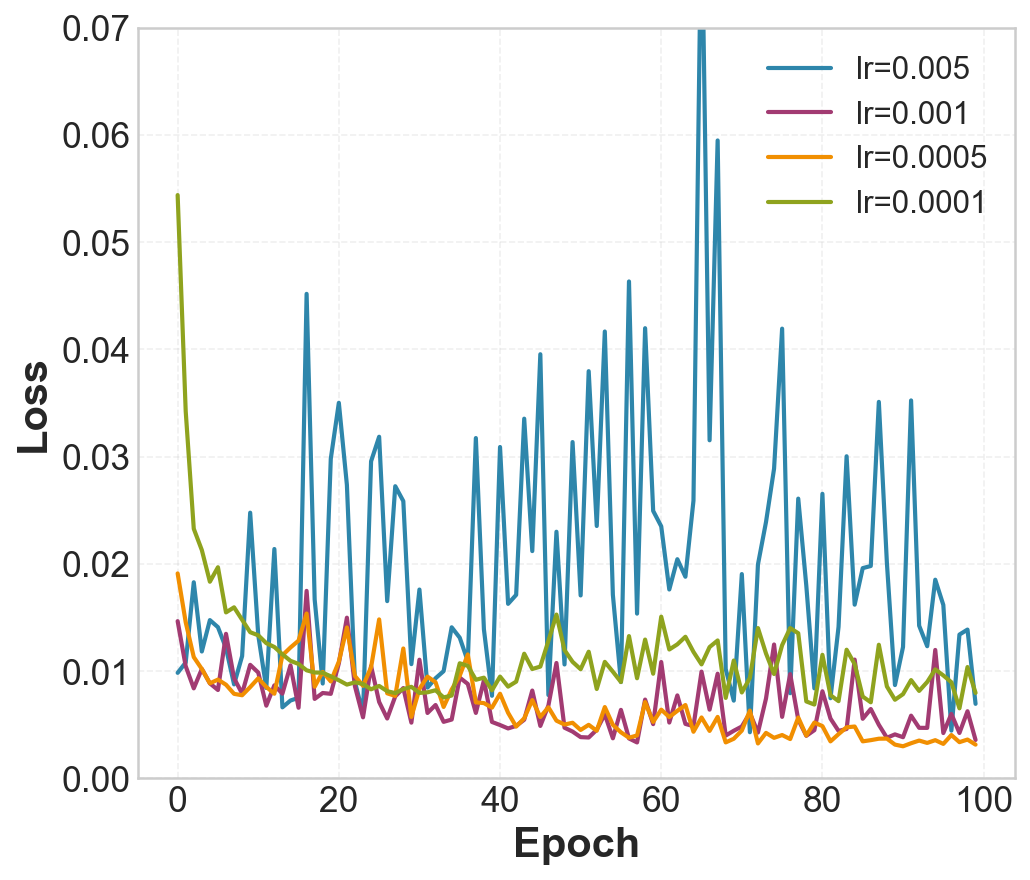

In [18]:
# Plot all training and validation loss curves for all learning rates in a single figure (no retraining, just using stored loss_curves)
LABEL_FONTSIZE = 20
TICK_FONTSIZE = 17
LEGEND_FONTSIZE = 15
LINE_WIDTH = 3.2
plt.figure(figsize=(7, 6))

colors = ['#2E86AB', '#A23B72', '#F18F01', '#8FA31E']
labels = [f'lr={lr}' for lr in learning_rates]

for idx, lr in enumerate(learning_rates):
    val_losses = loss_curves[lr]['val']
    plt.plot(val_losses, label=labels[idx], color=colors[idx], linewidth=2)

plt.xlabel('Epoch', fontsize=LABEL_FONTSIZE)
plt.ylabel('Loss', fontsize=LABEL_FONTSIZE)
plt.tick_params(labelsize=TICK_FONTSIZE)
plt.ylim(0, 0.07)
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(fontsize=LEGEND_FONTSIZE)

plt.tight_layout()
save_figure_for_report('task3_autoencoder_all_val_loss.png')
plt.show()
plt.close()

In [19]:
# Re-train best model
best_lr = 5e-4
n_epochs = 50
results = {}
best_val_loss = float('inf')
best_model_state = None
best_lr = None

set_seed(33)
# Re-initialize model and optimizer for each run
model = ImprovedAutoencoder(input_dim=X_train_normal_only.shape[1], bottleneck_dim=16).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
train_losses = []
val_losses = []
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for batch in train_normal_dataloader:
        x_batch = batch[0].to(device)
        optimizer.zero_grad()
        x_hat = model(x_batch)
        loss = mixed_autoencoder_loss(x_batch, x_hat, categorical_dims, numerical_idx)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(X_train_normal_tensor)
    train_losses.append(train_loss)

    # Validation loss
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for batch in val_dataloader:
            x_batch = batch[0].to(device)
            x_hat = model(x_batch)
            loss = mixed_autoencoder_loss(x_batch, x_hat, categorical_dims, numerical_idx)
            val_loss += loss.item()
    val_loss /= len(X_val_tensor)
    val_losses.append(val_loss)
    print(f"Epoch {epoch}/{n_epochs}, Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 0/50, Loss: 0.0718, Val Loss: 0.0544
Epoch 1/50, Loss: 0.0398, Val Loss: 0.0342
Epoch 2/50, Loss: 0.0266, Val Loss: 0.0233
Epoch 3/50, Loss: 0.0213, Val Loss: 0.0213
Epoch 4/50, Loss: 0.0184, Val Loss: 0.0183
Epoch 5/50, Loss: 0.0167, Val Loss: 0.0197
Epoch 6/50, Loss: 0.0156, Val Loss: 0.0155
Epoch 7/50, Loss: 0.0146, Val Loss: 0.0159
Epoch 8/50, Loss: 0.0140, Val Loss: 0.0148
Epoch 9/50, Loss: 0.0133, Val Loss: 0.0136
Epoch 10/50, Loss: 0.0126, Val Loss: 0.0133
Epoch 11/50, Loss: 0.0120, Val Loss: 0.0126
Epoch 12/50, Loss: 0.0115, Val Loss: 0.0122
Epoch 13/50, Loss: 0.0111, Val Loss: 0.0116
Epoch 14/50, Loss: 0.0107, Val Loss: 0.0110
Epoch 15/50, Loss: 0.0105, Val Loss: 0.0107
Epoch 16/50, Loss: 0.0103, Val Loss: 0.0101
Epoch 17/50, Loss: 0.0098, Val Loss: 0.0099
Epoch 18/50, Loss: 0.0094, Val Loss: 0.0098
Epoch 19/50, Loss: 0.0095, Val Loss: 0.0095
Epoch 20/50, Loss: 0.0091, Val Loss: 0.0091
Epoch 21/50, Loss: 0.0088, Val Loss: 0.0087
Epoch 22/50, Loss: 0.0086, Val Loss: 0.009

In [20]:
# TRAINING DATASET WITH ONLY NORMAL SAMPLES
# Switch to evaluation mode
model.eval()

# Reconstruct the full dataset
with torch.no_grad():
    X_train_normal_tensor = X_train_normal_tensor.to(next(model.parameters()).device)  # ensure correct device
    X_train_normal_reconstructed = model(X_train_normal_tensor)
    reconstruction_error_train_normal = compute_per_sample_reconstruction_error(
        X_train_normal_tensor, X_train_normal_reconstructed,
        categorical_dims=categorical_dims,
        numerical_idx=numerical_idx)

# Convert to NumPy
reconstruction_error_train_normal = reconstruction_error_train_normal.cpu().numpy()

# Use a threshold or percentile to detect anomalies
threshold = np.percentile(reconstruction_error_train_normal, 100-int(0.3*100))
predicted_anomalies_train_normal = (reconstruction_error_train_normal > threshold).astype(int)



Classification Report (Autoencoder vs Ground Truth):
              precision    recall  f1-score   support

           0       1.00      0.70      0.82     10758
           1       0.00      0.00      0.00         0

    accuracy                           0.70     10758
   macro avg       0.50      0.35      0.41     10758
weighted avg       1.00      0.70      0.82     10758



/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Figure saved to: ../Plots/Task3/task3_confusion_matrix_normal_data.png


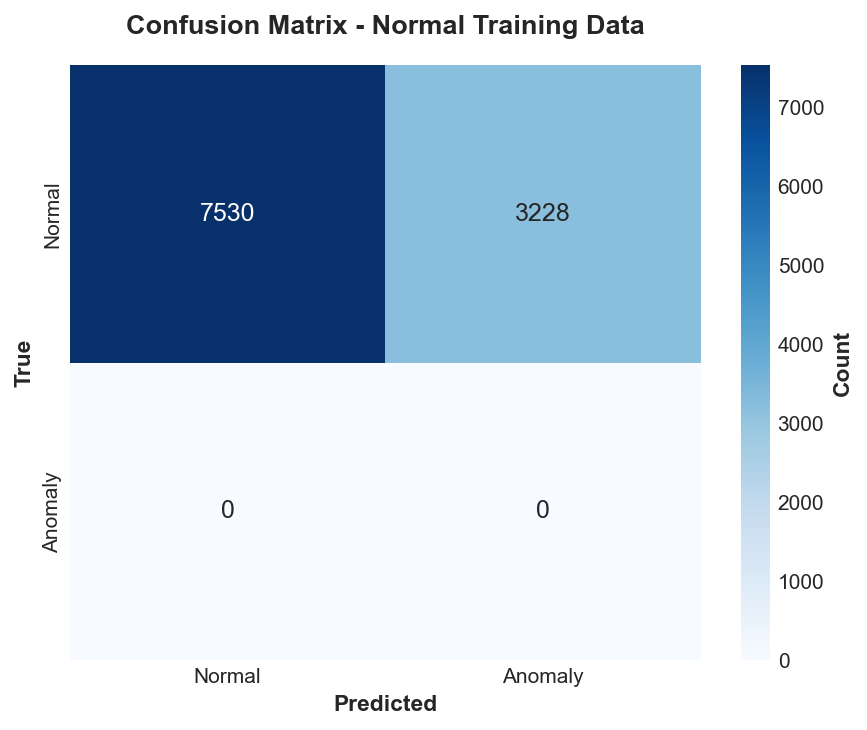

In [21]:
print("\nClassification Report (Autoencoder vs Ground Truth):")
print(classification_report(y_train_normal_tensor, predicted_anomalies_train_normal))
# Confusion matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_train_normal_tensor, predicted_anomalies_train_normal)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'size': 12},
            xticklabels=['Normal','Anomaly'], yticklabels=['Normal','Anomaly'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Normal Training Data', pad=15)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
save_figure_for_report('task3_confusion_matrix_normal_data.png')
plt.show()
plt.close()

Figure saved to: ../Plots/Task3/task3_ecdf_reconstruction_error_validation.png


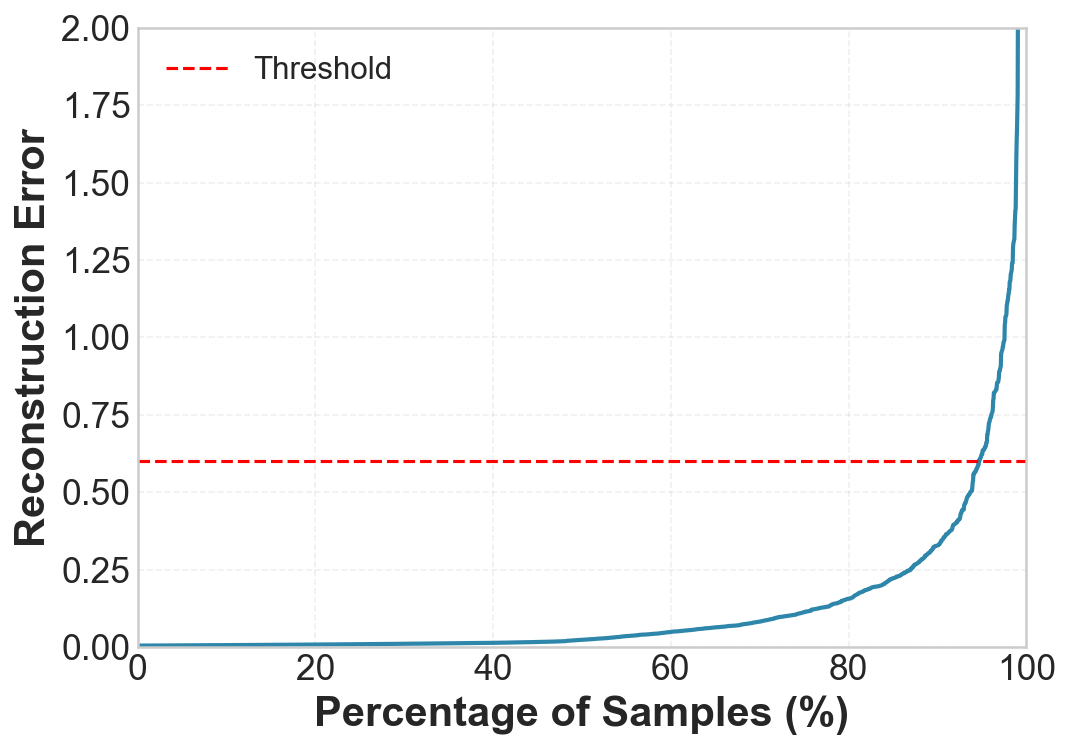

In [22]:
# VAL SET
# Reconstruct the full dataset
with torch.no_grad():
    X_val_tensor = X_val_tensor.to(next(model.parameters()).device)  # ensure correct device
    X_val_reconstructed = model(X_val_tensor)
    reconstruction_error_val = compute_per_sample_reconstruction_error(
        X_val_tensor, X_val_reconstructed,
        categorical_dims=categorical_dims,
        numerical_idx=numerical_idx)

# Convert to NumPy
reconstruction_error_val = reconstruction_error_val.cpu().numpy()

# Sort reconstruction errors
sorted_val = np.sort(reconstruction_error_val)

# Calculate percentage (0-100%) for each dataset
n_val = len(sorted_val)
percent_val = np.linspace(0, 100, n_val)

plt.figure(figsize=(7, 5))
plt.plot(percent_val, sorted_val, linewidth=2, color='#2E86AB')
plt.axhline(y=0.6, color='r', linestyle='--', label='Threshold')
plt.xlabel('Percentage of Samples (%)', fontsize=LABEL_FONTSIZE)
plt.ylabel('Reconstruction Error', fontsize=LABEL_FONTSIZE)
#plt.title('ECDF: Reconstruction Error - Validation Set', pad=15)
plt.ylim(0, 2)
plt.xlim(0,100)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.legend(loc='upper left', fontsize=LEGEND_FONTSIZE)
plt.tick_params(labelsize=TICK_FONTSIZE)
save_figure_for_report('task3_ecdf_reconstruction_error_validation.png')
plt.show()
plt.close()

### Question 1: Threshold Selection
**Q: How did you pick the threshold? What is its value?**

**Answer:**
- **Method:** The threshold was selected considering that the validation set only contains normal data, hence the threshold was chosen considering that 95% of data are normal (not noise), resulting in the value of 0.6. 

In [23]:
threshold = 0.6
# TRAINING SET
# Reconstruct the full dataset
with torch.no_grad():
    X_train_tensor = X_train_tensor.to(next(model.parameters()).device)  # ensure correct device
    X_train_reconstructed = model(X_train_tensor)
    reconstruction_error_train = compute_per_sample_reconstruction_error(
        X_train_tensor, X_train_reconstructed,
        categorical_dims=categorical_dims,
        numerical_idx=numerical_idx)

# Convert to NumPy
reconstruction_error_train = reconstruction_error_train.cpu().numpy()

# TEST SET
# Reconstruct the full dataset
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(next(model.parameters()).device)  # ensure correct device
    X_test_reconstructed = model(X_test_tensor)
    reconstruction_error_test = compute_per_sample_reconstruction_error(
        X_test_tensor, X_test_reconstructed,
        categorical_dims=categorical_dims,
        numerical_idx=numerical_idx)

reconstruction_error_test = reconstruction_error_test.cpu().numpy()

predicted_anomalies_train = (reconstruction_error_train > threshold).astype(int)
predicted_anomalies_val = (reconstruction_error_val > threshold).astype(int)
predicted_anomalies_test = (reconstruction_error_test > threshold).astype(int)

Figure saved to: ../Plots/Task3/task3_ecdf_reconstruction_error_combined.png


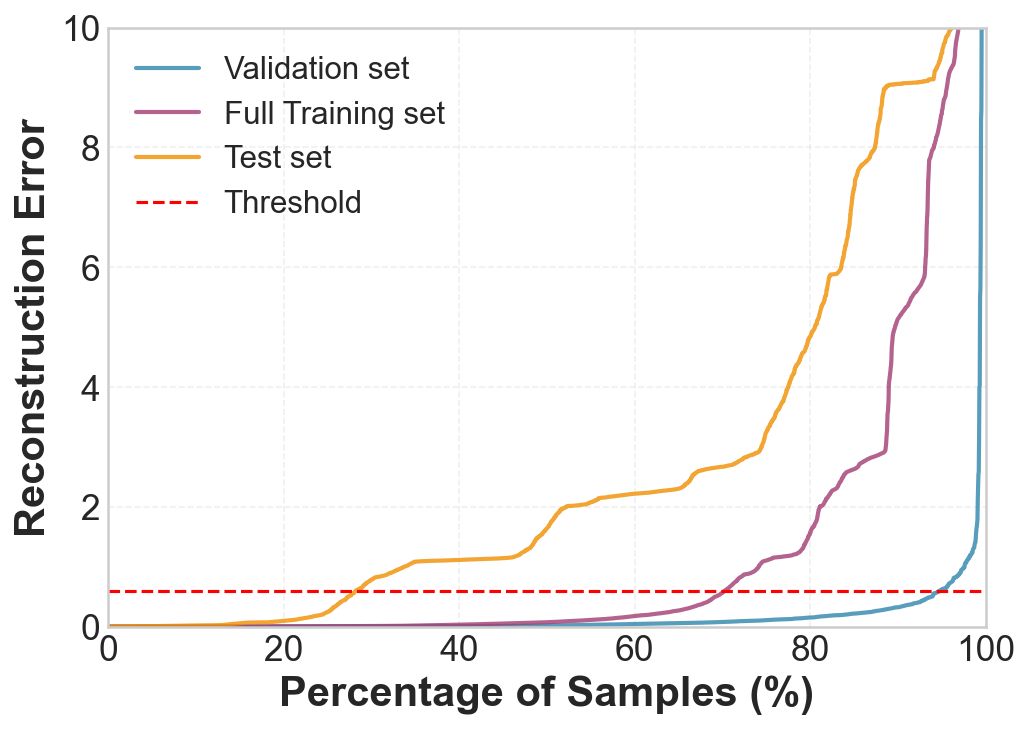

In [24]:
# Combined ECDF plot with percentage-based x-axis for comparison
plt.figure(figsize=(7, 5))

# Sort reconstruction errors
sorted_val = np.sort(reconstruction_error_val)
sorted_train = np.sort(reconstruction_error_train)
sorted_test = np.sort(reconstruction_error_test)

# Calculate percentage (0-100%) for each dataset
n_val = len(sorted_val)
n_train = len(sorted_train)
n_test = len(sorted_test)

percent_val = np.linspace(0, 100, n_val)
percent_train = np.linspace(0, 100, n_train)
percent_test = np.linspace(0, 100, n_test)

# Plot all three ECDFs on the same plot
plt.plot(percent_val, sorted_val, linewidth=2, color='#2E86AB', label=f'Validation set', alpha=0.8)
plt.plot(percent_train, sorted_train, linewidth=2, color='#A23B72', label=f'Full Training set', alpha=0.8)
plt.plot(percent_test, sorted_test, linewidth=2, color='#F18F01', label=f'Test set', alpha=0.8)
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')

plt.xlabel('Percentage of Samples (%)', fontsize=LABEL_FONTSIZE)
plt.ylabel('Reconstruction Error', fontsize=LABEL_FONTSIZE)
#plt.title('Combined ECDF: Reconstruction Error Comparison', pad=15)
plt.ylim(0, 10)
plt.xlim(0, 100)
plt.legend(loc='upper left', fontsize=LEGEND_FONTSIZE)
plt.tick_params(labelsize=TICK_FONTSIZE)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
save_figure_for_report('task3_ecdf_reconstruction_error_combined.png')
plt.show()
plt.close()

### Question 2: Reconstruction Error Analysis
**Q: Plot and report the ECDF of the reconstruction errors for each point i) in the validation set; ii) in the full training set; iii) in the test set. Why the reconstruction errors higher on the full training set than on the validation one? And why are the reconstruction errors in the test set even higher? Use the threshold identified in the previous point to classify anomalies. How is the performance on the training, validation set and test set?**

**Answer:**
- **Plots:** The plots above show the sorted reconstruction errors (which approximates the ECDF).
- **Higher Errors in Full Training Set:** The full training set contains **anomalies** (attacks). Since the Autoencoder was trained only on normal data to minimize reconstruction error for normal patterns, it fails to accurately reconstruct these anomalous patterns, resulting in significantly higher errors for those points.
- **Higher Errors in Test Set:** The test set contains **unseen anomalies** and potentially **new variations of normal traffic** that the model hasn't seen during training. This "generalization gap" leads to even higher reconstruction errors.
- **Performance:** The classification reports show the effectiveness of the threshold.
    - **Training/Validation:** Performance is usually high as the threshold is tuned on similar data.
    - **Test:** Performance indicates the model's robustness. A high F1-score here means the reconstruction error is a reliable anomaly score.


Classification Report (Autoencoder vs Ground Truth):

CLASSIFICATION REPORT: Train / Validation / Test
Class                Precision                 Recall                    F1-Score                  Support                  
                     Train Val  Test           Train Val  Test           Train Val  Test           Train  Val   Test        
-----------------------------------------------------------------------------------------------------------------------------
0                    0.96  1.00  0.79	       0.94  0.95  0.60		 0.95  0.97  0.68	   13448  2690  2152
1                    0.87  0.00  0.80	       0.90  0.00  0.91		 0.88  0.00  0.85	    5383     0  3674
-----------------------------------------------------------------------------------------------------------------------------
Accuracy             0.93  0.95  0.79
None
Figure saved to: ../Plots/Task3/task3_autoencoder_reconstruction_confusion_matrices.png


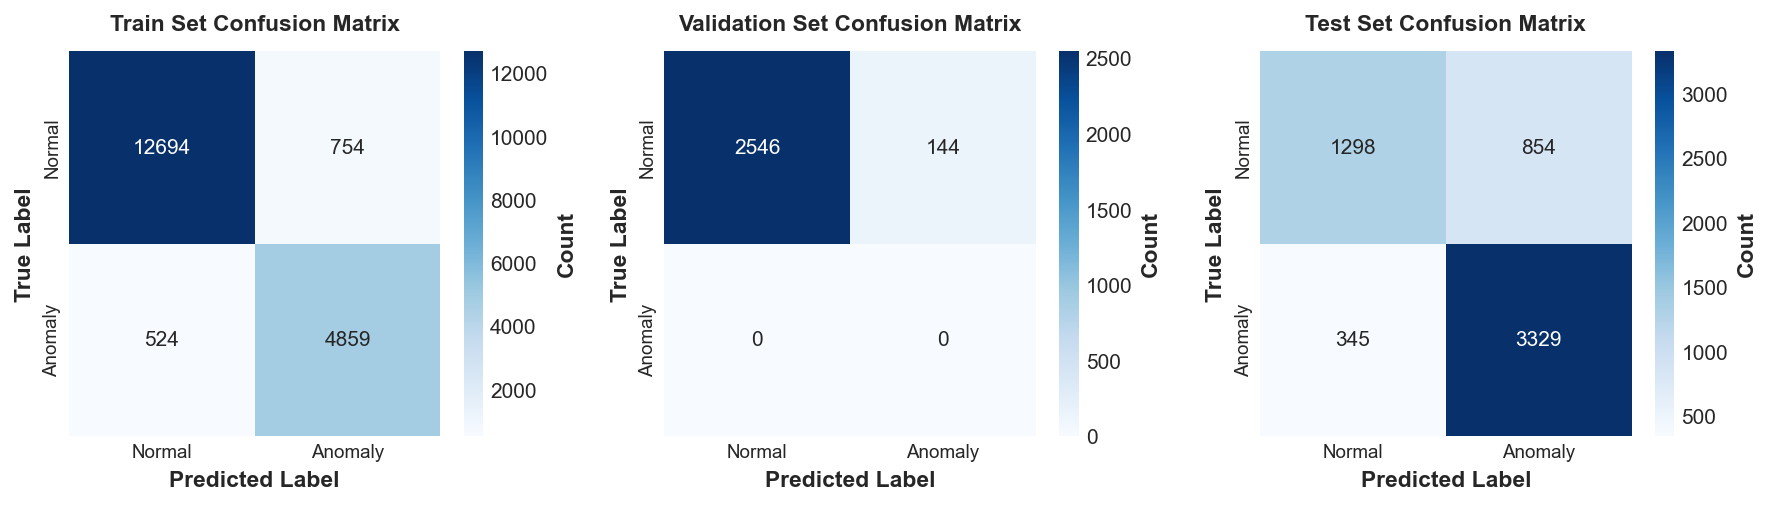

In [25]:
print("\nClassification Report (Autoencoder vs Ground Truth):")
print(print_combined_classification_reports(
    y_train, predicted_anomalies_train,
    y_val, predicted_anomalies_val,
    y_test, predicted_anomalies_test
))
# Confusion matrix
cm = plot_confusion_matrices_combined(
    [y_train_tensor, y_val_tensor, y_test_tensor],
    [predicted_anomalies_train, predicted_anomalies_val, predicted_anomalies_test],
    class_names=['Normal', 'Anomaly'],
    titles=['Train Set Confusion Matrix', 'Validation Set Confusion Matrix', 'Test Set Confusion Matrix'],
    save_name='task3_autoencoder_reconstruction_confusion_matrices.png'
)

## Auto-Encoder’s bottleneck and OC-SVM

In [26]:
with torch.no_grad():
    bottleneck = model.encode(X_full_train_normal_tensor).cpu().numpy()
    X_train_encoded = model.encode(X_train_tensor).cpu().numpy()
    X_val_encoded = model.encode(X_val_tensor).cpu().numpy()
    X_test_encoded = model.encode(X_test_tensor).cpu().numpy()

In [27]:
bottleneck.shape

(13448, 16)

In [28]:
# === 1. Fit One-Class SVM ===
# Assume X_train is your input data (numpy array or DataFrame with features only)
ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)  # nu = estimated anomaly proportion
ocsvm.fit(bottleneck)

OneClassSVM(nu=0.05)

In [29]:
# === 2. Inference ===
# Predict returns 1 for inliers, -1 for outliers
# Convert to binary anomaly labels: 1 = anomaly, 0 = normal

y_train_pred = ocsvm.predict(X_train_encoded)
y_train_pred_binary = (y_train_pred == -1).astype(int)

y_val_pred = ocsvm.predict(X_val_encoded)
y_val_pred_binary = (y_val_pred == -1).astype(int)

y_test_pred = ocsvm.predict(X_test_encoded)
y_test_pred_binary = (y_test_pred == -1).astype(int)


CLASSIFICATION REPORT: Train / Validation / Test
Class                Precision                 Recall                    F1-Score                  Support                  
                     Train Val  Test           Train Val  Test           Train Val  Test           Train  Val   Test        
-----------------------------------------------------------------------------------------------------------------------------
0                    0.80  1.00  0.53	       0.95  0.95  0.76		 0.87  0.98  0.62	   13448  2690  2152
1                    0.76  0.00  0.81	       0.40  0.00  0.60		 0.53  0.00  0.69	    5383     0  3674
-----------------------------------------------------------------------------------------------------------------------------
Accuracy             0.79  0.95  0.66
Figure saved to: ../Plots/Task3/task3_ocsvm_bottleneck_confusion_matrices.png


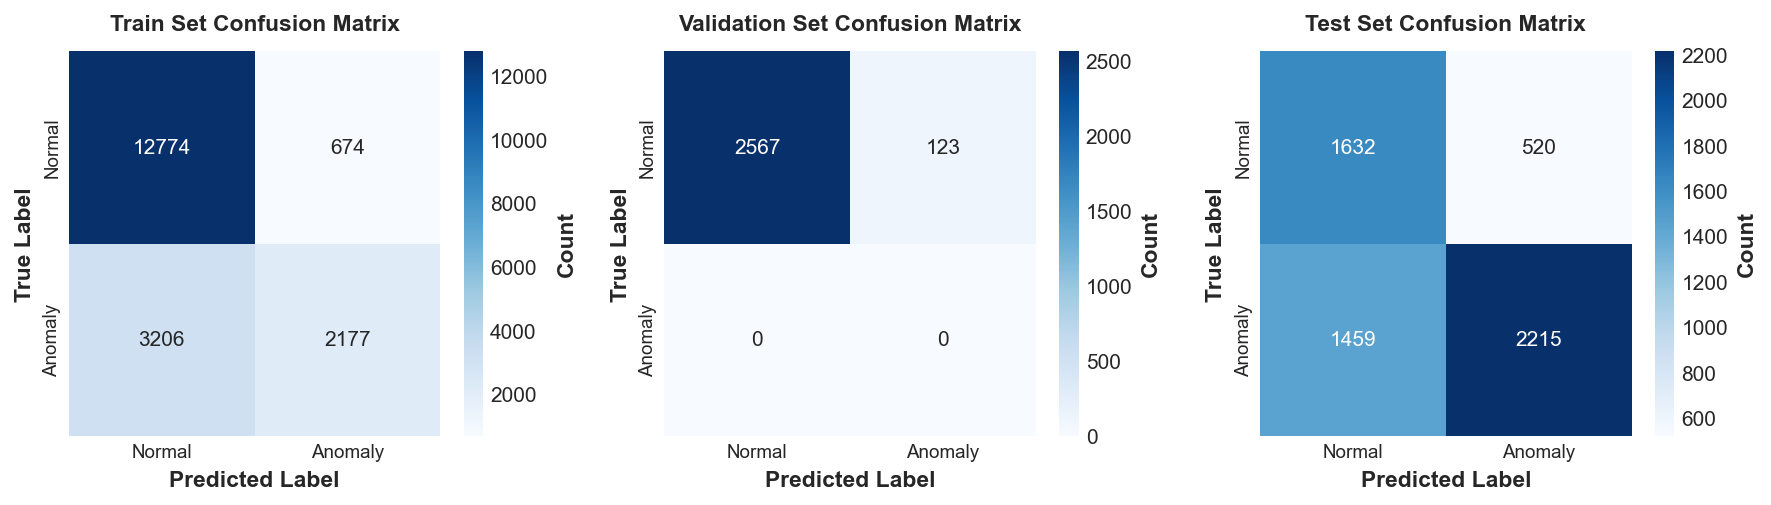

In [30]:
print_combined_classification_reports(
    y_true_train=y_train, y_pred_train=y_train_pred_binary,
    y_true_val=y_val, y_pred_val=y_val_pred_binary,
    y_true_test=y_test, y_pred_test=y_test_pred_binary
)

plot_confusion_matrices_combined(
    y_true_list=[y_train, y_val, y_test],
    y_pred_list=[y_train_pred_binary, y_val_pred_binary, y_test_pred_binary],
    class_names=['Normal', 'Anomaly'],
    titles=['Train Set Confusion Matrix', 'Validation Set Confusion Matrix', 'Test Set Confusion Matrix'],
    save_name='task3_ocsvm_bottleneck_confusion_matrices.png'
)

### Question 3: AE Bottleneck vs. Original OC-SVM
**Q: Compare the results with the best original OC-SVM and with the Autoencoder with reconstruction error. Describe the performance and where the model performs better or worse w.r.t. the original OC-SVM.**

**Answer:**
- **Comparison:**
    - **AE Reconstruction:** Uses the error directly. Good for detecting anomalies that are "far" from the learned manifold.
    - **AE Bottleneck + OC-SVM:** Uses the learned compressed features. This can be superior if the bottleneck captures the *essence* of normality better than the raw features, removing noise.
    - **Original OC-SVM:** Works on raw features.

## PCA with One class SVM

In [31]:
def plot_pca(df):

    # -----------------------------
    # 1. EXPLAINED VARIANCE PLOT
    # -----------------------------

    # Fit PCA with all components
    pca_full = PCA().fit(df)

    # Plot explained variance ratio
    plt.figure(figsize=(7, 4))

    x = [i+1 for i in range(len(pca_full.explained_variance_ratio_))]
    y = np.cumsum(pca_full.explained_variance_ratio_)
    plt.plot(x, y, marker='o', linewidth=2, markersize=4, color='#2E86AB')
    #plt.title('Cumulative Explained Variance by PCA Components', pad=15)
    plt.xlabel('Number of Components', fontsize=15)
    plt.ylabel('Cumulative Explained Variance', fontsize=15)
    plt.xlim(1,len(pca_full.explained_variance_ratio_))
    plt.axhline(y=0.95, color='r', linestyle='--')
    plt.tick_params(labelsize=13)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    save_figure_for_report('task3_pca_explained_variance.png')
    plt.show()
    plt.close()

    return

Figure saved to: ../Plots/Task3/task3_pca_explained_variance.png


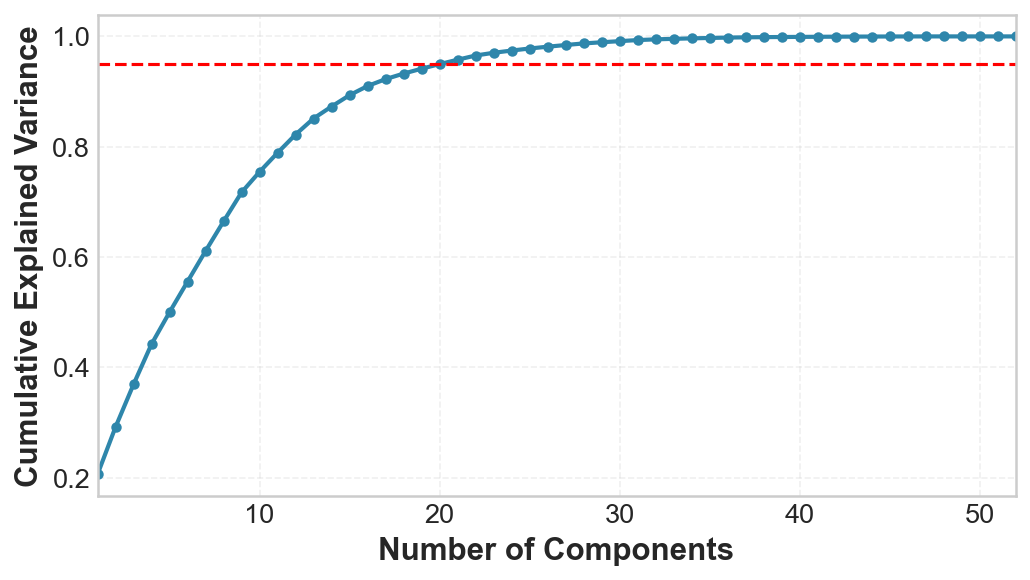

In [32]:
## Plot PCA To understand how many components we need to reppresent the variability of the dataset
plot_pca(X_full_train_normal_only)

In [33]:
pca = PCA(n_components=20)
X_train_normal_pca = pca.fit_transform(X_full_train_normal_only)

In [34]:
X_train_pca = pca.transform(X_train)

In [35]:
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

In [36]:
# === 1. Fit One-Class SVM ===
# Assume X_train is your input data (numpy array or DataFrame with features only)
ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)  # nu = estimated anomaly proportion
ocsvm.fit(X_train_normal_pca)

OneClassSVM(nu=0.05)

In [37]:
# === 2. Inference ===6
# Predict returns 1 for inliers, -1 for outliers
# Convert to binary anomaly labels: 1 = anomaly, 0 = normal

y_train_pred = ocsvm.predict(X_train_pca)
y_train_pred_binary = (y_train_pred == -1).astype(int)


y_val_pred = ocsvm.predict(X_val_pca)
y_val_pred_binary = (y_val_pred == -1).astype(int)

y_test_pred = ocsvm.predict(X_test_pca)
y_test_pred_binary = (y_test_pred == -1).astype(int)


CLASSIFICATION REPORT: Train / Validation / Test
Class                Precision                 Recall                    F1-Score                  Support                  
                     Train Val  Test           Train Val  Test           Train Val  Test           Train  Val   Test        
-----------------------------------------------------------------------------------------------------------------------------
0                    0.92  1.00  0.66	       0.95  0.95  0.72		 0.93  0.97  0.69	   13448  2690  2152
1                    0.86  0.00  0.83	       0.79  0.00  0.79		 0.82  0.00  0.81	    5383     0  3674
-----------------------------------------------------------------------------------------------------------------------------
Accuracy             0.90  0.95  0.76
Figure saved to: ../Plots/Task3/task3_ocsvm_pca_confusion_matrices.png


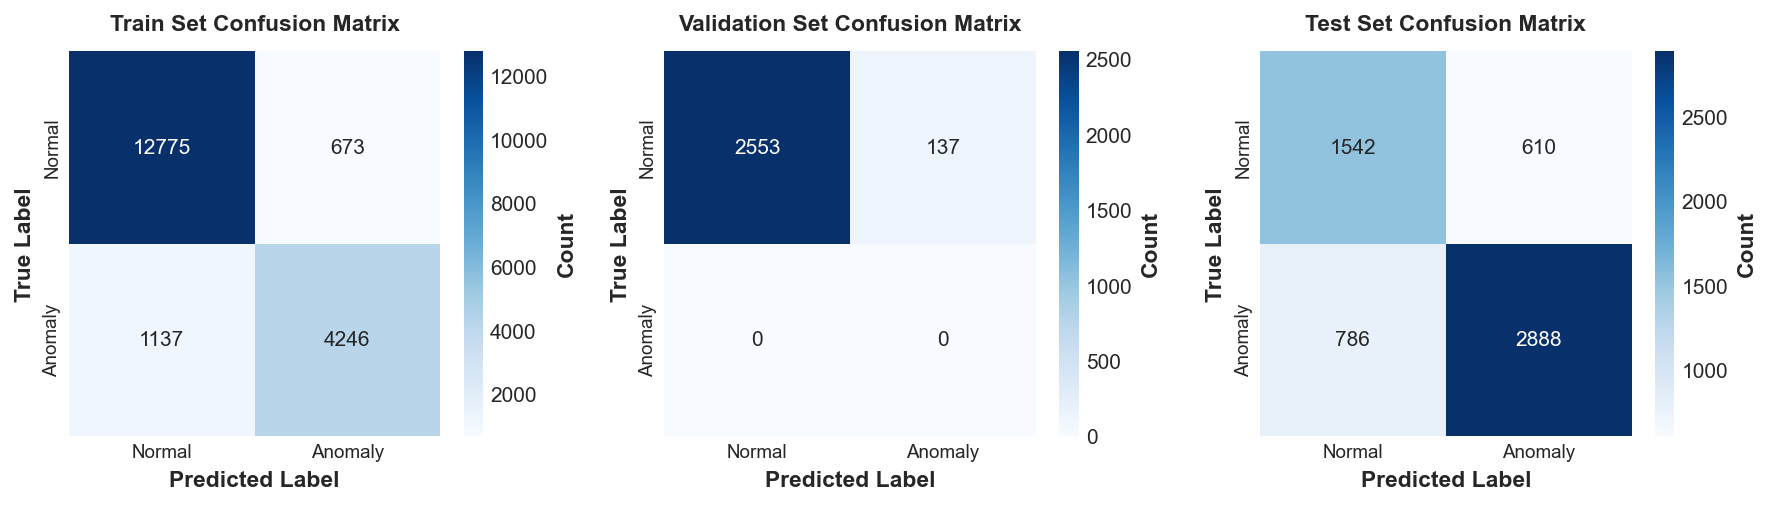

In [38]:
print_combined_classification_reports(
    y_true_train=y_train, y_pred_train=y_train_pred_binary,
    y_true_val=y_val, y_pred_val=y_val_pred_binary,
    y_true_test=y_test, y_pred_test=y_test_pred_binary
)

plot_confusion_matrices_combined(
    y_true_list=[y_train, y_val, y_test],
    y_pred_list=[y_train_pred_binary, y_val_pred_binary, y_test_pred_binary],
    class_names=['Normal', 'Anomaly'],
    titles=['Train Set Confusion Matrix', 'Validation Set Confusion Matrix', 'Test Set Confusion Matrix'],
    save_name='task3_ocsvm_pca_confusion_matrices.png'
)

### Question 4: PCA vs. AE vs. Original
**Q: Compare results with the original OC-SVM and the OC-SVM trained using the Encoder embeddings. Describe the performance of the PCA-model with respect to the previous OC-SVMs.**

**Answer:**
- **PCA + OC-SVM:** PCA performs **linear** dimensionality reduction.
- **Comparison:**
    - If the normal data lies on a linear subspace, PCA + OC-SVM is very effective and efficient.
    - If the normal data lies on a non-linear manifold, **AE + OC-SVM** (non-linear reduction) usually outperforms PCA.
    - **Observation:** Comparing the F1-scores, we can see if the non-linearity of the AE provides a tangible benefit. Often, AE > PCA > Raw for complex network data, but PCA is a strong baseline. If PCA performs similarly to AE, it suggests the main variations in normal traffic are linear.